# MSc Statistics for Smart Data - Spark Project - December 2018
## Audrey Comemale

In [1]:
### Starting spark context 
import pyspark
import os

os.environ['SPARK_HOME'] = '/home/acom/spark/spark-2.3.2-bin-hadoop2.7/'
sc = pyspark.SparkContext() #it is possible to specifiy master = 'local[2]' to specify the number of cores that will be used

In [3]:
#checking
sc 

<SparkContext master=local[*] appName=pyspark-shell>

In [4]:
#starting SQL Context
sql_sc = pyspark.SQLContext(sc)

# Optional function to download the data

In [12]:
#Function to download data
import urllib

def download_from_url(url, directory, filename):
    
    
    #directory : string of the directory where to save the file
    #filename : name of the file to save in the directory - string
    
    
    save_path = "/".join((directory, filename))
    urllib.request.urlretrieve(url = url, filename = save_path)

In [14]:
#Download prices for years 2014 > 2017
download_from_url("https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Prix2017.zip","/home/acom/IT_Tools2","Prix2017.zip")
download_from_url("https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Prix2016.zip","/home/acom/IT_Tools2","Prix2016.zip")
download_from_url("https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Prix2015.zip","/home/acom/IT_Tools2","Prix2015.zip")
download_from_url("https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Prix2014.zip","/home/acom/IT_Tools2","Prix2014.zip")

In [ ]:
#Download additional data
download_from_url("https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Services2017.zip","/home/acom/IT_Tools2","Services2017.zip")
download_from_url("https://raw.githubusercontent.com/rvm-courses/GasPrices/master/Stations2017.zip","/home/acom/IT_Tools2","Stations2017.zip")

# Preparation Step

In [5]:
#Read CSV file of prices in 2014
RDD = sql_sc.read.option('header', 'false').option('sep', ';').option('inferSchema', 'true').csv('Prix2014.csv') 

In [6]:
RDD.show()

+-------+----+---+---------+--------+-------------------+---+------+----+
|    _c0| _c1|_c2|      _c3|     _c4|                _c5|_c6|   _c7| _c8|
+-------+----+---+---------+--------+-------------------+---+------+----+
|1000001|1000|  R|4620114.0|519791.0|2014-01-02 11:08:03|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2014-01-04 09:54:03|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2014-01-05 10:27:09|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2014-01-06 09:07:51|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2014-01-07 09:23:56|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2014-01-10 10:47:46|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2014-01-11 09:31:56|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2014-01-13 09:24:30|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2014-01-15 09:51:51|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2014-01-16 09:46:41|  1|Gazole|1304|
|1000001|1000|  R|4620114.0|519791.0|2

In [7]:
from pyspark.sql.functions import split, ceil
from pyspark.sql.functions import *

### Preparation of the data, step1 :
1. Add columns for the date, the year, the month and the day of the month.
 2. Add a colummn for the day of the year. It will be usefull for calculating predictions with the random forest.
 3. Add a column for the week index : calculation of the number of weeks starting from 01/01/2014. It is an approximation since all months do not have 30 days.
 4. Add a column for the week of the year
 5. Add two columns for the latitude and the longitude

In [8]:
RDD = RDD.withColumn('Date', split(RDD._c5, ' ')[0])
RDD = RDD.withColumn('Year', split(RDD.Date, '-')[0])
RDD = RDD.withColumn('Month', split(RDD.Date, '-')[1])
RDD = RDD.withColumn('Day_of_month', split(RDD.Date, '-')[2])
RDD = RDD.withColumn('Day_number',  dayofyear(RDD.Date))
RDD = RDD.withColumn('Week_Index', ceil(52*(split(RDD.Date, '-')[0] - 2014)+(split(RDD.Date, '-')[2]+ (split(RDD.Date, '-')[1]-1)*30)/7)) #approximation of the number of day in months to 30
RDD = RDD.withColumn('Week_of_the_year', ceil((split(RDD.Date, '-')[2]+ (split(RDD.Date, '-')[1]-1)*30)/7))
RDD = RDD.withColumn('Latitude', RDD._c3 / 10**5)
RDD = RDD.withColumn('Longitude', RDD._c4 / 10**4)
RDD.show()

+-------+----+---+---------+--------+-------------------+---+------+----+----------+----+-----+------------+----------+----------+----------------+--------+---------+
|    _c0| _c1|_c2|      _c3|     _c4|                _c5|_c6|   _c7| _c8|      Date|Year|Month|Day_of_month|Day_number|Week_Index|Week_of_the_year|Latitude|Longitude|
+-------+----+---+---------+--------+-------------------+---+------+----+----------+----+-----+------------+----------+----------+----------------+--------+---------+
|1000001|1000|  R|4620114.0|519791.0|2014-01-02 11:08:03|  1|Gazole|1304|2014-01-02|2014|   01|          02|         2|         1|               1|46.20114|  51.9791|
|1000001|1000|  R|4620114.0|519791.0|2014-01-04 09:54:03|  1|Gazole|1304|2014-01-04|2014|   01|          04|         4|         1|               1|46.20114|  51.9791|
|1000001|1000|  R|4620114.0|519791.0|2014-01-05 10:27:09|  1|Gazole|1304|2014-01-05|2014|   01|          05|         5|         1|               1|46.20114|  51.9791

The previous step is repeated for the next years ; 2015, 2016 and 2017. The data is added using union to RDD.

In [9]:
years = ['Prix2015.csv','Prix2016.csv','Prix2017.csv']

for i in years:
    dataframe = (sql_sc
                 .read.option('header', 'false')
                 .option('sep', ';')
                 .option('inferSchema', 'true')
                 .csv(i))
    
    
    dataframe = dataframe.withColumn('Date', split(dataframe._c5, ' ')[0])
    dataframe = dataframe.withColumn('Year', split(dataframe.Date, '-')[0])
    dataframe = dataframe.withColumn('Month', split(dataframe.Date, '-')[1])
    dataframe = dataframe.withColumn('Day_of_month', split(dataframe.Date, '-')[2])
    dataframe = dataframe.withColumn('Day_number',  dayofyear(dataframe.Date)+365*(split(dataframe.Date, '-')[0]-2014))
    dataframe = dataframe.withColumn('Week_index', ceil(52*(split(dataframe.Date, '-')[0] - 2014)+(split(dataframe.Date, '-')[2]+ (split(dataframe.Date, '-')[1]-1)*30)/7))
    dataframe = dataframe.withColumn('Week_of_the_year', ceil((split(dataframe.Date, '-')[2]+ (split(dataframe.Date, '-')[1]-1)*30)/7))
    dataframe = dataframe.withColumn('Latitude', dataframe._c3 / 10**5)
    dataframe = dataframe.withColumn('Longitude', dataframe._c4 / 10**4 )
    RDD = RDD.union(dataframe)
    
RDD.show()

+-------+----+---+---------+--------+-------------------+---+------+----+----------+----+-----+------------+----------+----------+----------------+--------+---------+
|    _c0| _c1|_c2|      _c3|     _c4|                _c5|_c6|   _c7| _c8|      Date|Year|Month|Day_of_month|Day_number|Week_Index|Week_of_the_year|Latitude|Longitude|
+-------+----+---+---------+--------+-------------------+---+------+----+----------+----+-----+------------+----------+----------+----------------+--------+---------+
|1000001|1000|  R|4620114.0|519791.0|2014-01-02 11:08:03|  1|Gazole|1304|2014-01-02|2014|   01|          02|       2.0|         1|               1|46.20114|  51.9791|
|1000001|1000|  R|4620114.0|519791.0|2014-01-04 09:54:03|  1|Gazole|1304|2014-01-04|2014|   01|          04|       4.0|         1|               1|46.20114|  51.9791|
|1000001|1000|  R|4620114.0|519791.0|2014-01-05 10:27:09|  1|Gazole|1304|2014-01-05|2014|   01|          05|       5.0|         1|               1|46.20114|  51.9791

In [10]:
#create a table from the dataframe RDD :
RDD.createOrReplaceTempView("GasPrices_table")

### Data preparation, step 2

##### Objective : to compute the price index.
 1. Get the average day price in France
 2. Get the day price in station
 
 Method : use sql queries and save the result into tables

 Result : 
 
- the daily price tables (over france and per station) to compute the daily price index and to plot the weekly evolution of the prices

In [11]:
# For a price index based on day averages
#average day price in france per gas type
avg_day_price = sql_sc.sql('select avg(_c8) as france_day_avg, _c7 as gas_france, Week_Index, Day_number as Day_n from GasPrices_table '
                           'group by _c7, Day_n, Week_Index order by Week_Index desc').registerTempTable("avg_day_price")
#average day price in france per gas type and per station
station_day_price = sql_sc.sql('select avg(_c8) as station_day_avg, _c7 as gas_type, Week_Index as Wk_I, _c0, Day_number  from GasPrices_table '
                               'group by _c7,  _c0, Day_number, Wk_I order by Wk_I desc').registerTempTable("station_day_price")

In [28]:
#To check the results :
#comment or uncomment to choose what to see 

#sql_sc.sql('select * from station_day_price').show(5)
#sql_sc.sql('select * from avg_day_price').show(5)

+---------------+-----------+----+--------+----------+
|station_day_avg|gas_station|Wk_I|     _c0|Day_number|
+---------------+-----------+----+--------+----------+
|         1429.0|        E10| 208| 2603001|    1459.0|
|         1450.0|        E10| 208|13015013|    1457.0|
|         1409.0|        E10| 208| 6270003|    1458.0|
|         1372.0|        E10| 208| 1170003|    1458.0|
|         1475.0|        E10| 208| 6800017|    1460.0|
+---------------+-----------+----+--------+----------+
only showing top 5 rows

+------------------+----------+----------+------+
|    france_day_avg|gas_france|Week_Index| Day_n|
+------------------+----------+----------+------+
|1480.6007140731924|      SP98|       208|1457.0|
| 805.3081761006289|      GPLc|       208|1460.0|
|1417.9835666463787|      SP95|       208|1458.0|
| 1393.273805601318|       E10|       208|1457.0|
|1504.8455507644062|      SP98|       208|1460.0|
+------------------+----------+----------+------+
only showing top 5 rows



In [12]:
# Merge the previous table into one. 

#for the day average in france and in station. 
sql_sc.sql('select * from station_day_price left outer '
           'join avg_day_price on station_day_price.Wk_I = avg_day_price.Week_Index and station_day_price.gas_type = avg_day_price.gas_france and station_day_price.Day_number = avg_day_price.Day_n '
           'order by avg_day_price.Week_Index desc').registerTempTable("price_index_day_table")

In [33]:
#checking
#comment or uncomment to choose what to see
#sql_sc.sql('select station_avg from price_index_table').show(10)

+-----------+
|station_avg|
+-----------+
|     1409.0|
|     1423.0|
|     1415.6|
|     1419.0|
|     1405.0|
|     1409.0|
|     1500.0|
|     1407.0|
|     1367.5|
|     1510.0|
+-----------+
only showing top 10 rows



In [13]:
#day - checking 
#comment or uncomment to choose what to see
sql_sc.sql('select * from price_index_day_table').show(10)

+---------------+--------+----+--------+----------+-----------------+----------+----------+------+
|station_day_avg|gas_type|Wk_I|     _c0|Day_number|   france_day_avg|gas_france|Week_Index| Day_n|
+---------------+--------+----+--------+----------+-----------------+----------+----------+------+
|          819.0|    GPLc| 208|78140008|    1458.0|797.3269230769231|      GPLc|       208|1458.0|
|          748.0|    GPLc| 208|49003001|    1458.0|797.3269230769231|      GPLc|       208|1458.0|
|          759.0|    GPLc| 208|78000020|    1458.0|797.3269230769231|      GPLc|       208|1458.0|
|         1409.0|    GPLc| 208|38140001|    1458.0|797.3269230769231|      GPLc|       208|1458.0|
|          879.0|    GPLc| 208|66300013|    1458.0|797.3269230769231|      GPLc|       208|1458.0|
|          819.0|    GPLc| 208|57100007|    1458.0|797.3269230769231|      GPLc|       208|1458.0|
|          839.0|    GPLc| 208|69260010|    1458.0|797.3269230769231|      GPLc|       208|1458.0|
|         

Computation of the day price index : (no average on the weeks)

In [14]:
sql_sc.sql('select station_day_avg, france_day_avg, 100*(1+(station_day_avg-france_day_avg)/france_day_avg) as Price_day_Index, Week_Index, gas_type, _c0 from price_index_day_table group by station_day_avg, france_day_avg, Week_Index, gas_type, _c0').show()


#there are NA. They are removed in the sequel

+---------------+-----------------+------------------+----------+--------+--------+
|station_day_avg|   france_day_avg|   Price_day_Index|Week_Index|gas_type|     _c0|
+---------------+-----------------+------------------+----------+--------+--------+
|          739.0|797.3269230769231|  92.6846916379248|       208|    GPLc|13013016|
|         1409.0|797.3269230769231|176.71546754781602|       208|    GPLc|38140001|
|          907.0|797.3269230769231|113.75509514965871|       208|    GPLc|63200001|
|          879.0|797.3269230769231| 110.2433612310364|       208|    GPLc|66300013|
|          748.0|797.3269230769231| 93.81346325462484|       208|    GPLc|49003001|
|          819.0|797.3269230769231|102.71821711970286|       208|    GPLc|57100007|
|          839.0|797.3269230769231|105.22659849014737|       208|    GPLc|69260010|
|          759.0|797.3269230769231| 95.19307300836931|       208|    GPLc|78000020|
|          819.0|797.3269230769231|102.71821711970286|       208|    GPLc|78

In [15]:
#Recording the daily price index as "price_day_index_table2"
sql_sc.sql('select station_day_avg, france_day_avg, 100*(1+(station_day_avg-france_day_avg)/france_day_avg) as Price_day_Index, Week_Index, gas_type, _c0 '
           'from price_index_day_table group by station_day_avg, france_day_avg, Week_Index, gas_type, _c0').registerTempTable("price_day_index_table2")


### Data visualization step : 
Represent weekly evolution of the average gas price in france

Below, the price index by week is calculated by averaging the daily price index.

In [16]:
#table of the average price indexes by week and by gas type in france (average over stations and over)
sql_sc.sql('select avg(Price_day_Index) as avg_price_day_index, Week_Index, gas_type from price_day_index_table2 group by Week_Index, gas_type').registerTempTable("avg_price_day_index_table")

In [17]:
#To check :
sql_sc.sql('select * from avg_price_day_index_table').show()

+-------------------+----------+--------+
|avg_price_day_index|Week_Index|gas_type|
+-------------------+----------+--------+
|  99.97947636522666|       208|    GPLc|
|  100.1641897948687|       208|     E10|
| 100.07767920537572|       208|    SP95|
|   100.165690730048|       208|  Gazole|
| 100.08421527904599|       208|     E85|
| 100.18893536806276|       208|    SP98|
|  100.1348835274657|       207|    SP98|
| 100.08166500229245|       207|    GPLc|
| 100.12785596283277|       207|  Gazole|
| 100.11802521556275|       207|     E10|
|  100.1182484014579|       207|     E85|
|  100.0689858046051|       207|    SP95|
|   100.147860328571|       206|    GPLc|
| 100.20249918455254|       206|     E10|
| 100.19405128587113|       206|  Gazole|
| 100.05382285887168|       206|    SP95|
| 100.12118481344358|       206|     E85|
| 100.22962696324721|       206|    SP98|
| 100.07117884848901|       205|     E85|
| 100.05592675763074|       205|    SP95|
+-------------------+----------+--

Now, the average week price is calculated for visualization.

In [18]:
#table of the price averages by week and by gas type in france (average over stations and over)
sql_sc.sql('select avg(france_day_avg) as avg_day_to_week_price, Week_Index, gas_type from price_day_index_table2 group by Week_Index, gas_type').registerTempTable("avg_price_day_to_week_table")

In [19]:
#we plot the weekly evolution of the price index and the price averages. 
PI_dataset = sql_sc.sql('select * from avg_price_day_to_week_table').toPandas() #seaborn requires a panda dataframe
PI_daily_dataset = sql_sc.sql('select * from avg_price_day_index_table').toPandas()

In [20]:
#Seaborn is used
import seaborn as sns
sns.set()

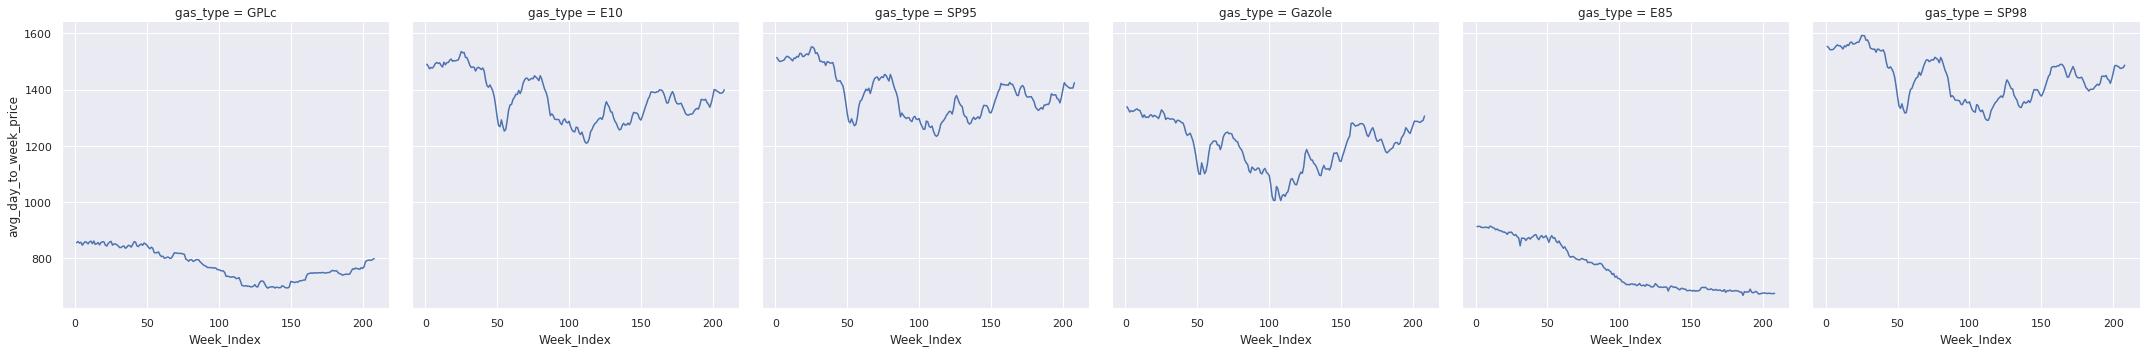

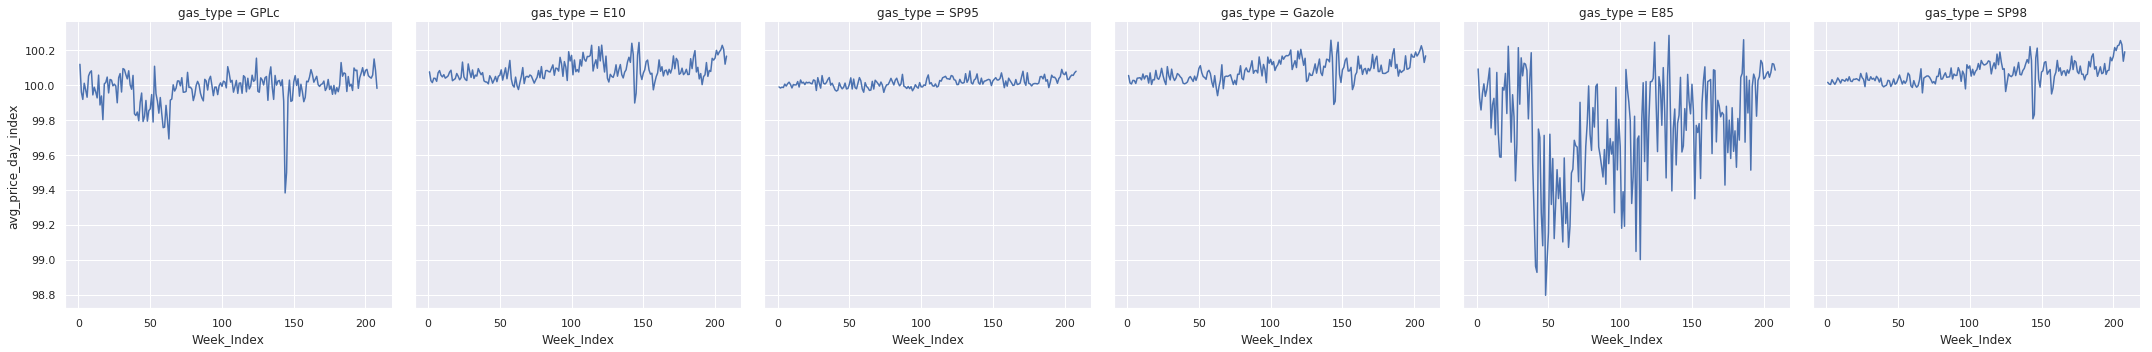

In [21]:
#plotting : 
#The weekly evolution of the average price per gas type in France
sns.relplot(x="Week_Index", y="avg_day_to_week_price", col="gas_type", kind="line", legend="full",data=PI_dataset)

#the weekly evolution of the price index per gas type in France
sns.relplot(x="Week_Index", y="avg_price_day_index", col="gas_type", kind="line", legend="full",data=PI_daily_dataset)

### Heatmap

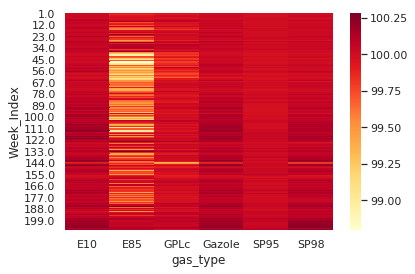

In [22]:
#Creation of a heatmap using seaborn from the PI_daily_dataset
import pandas as pd
#the dataframe passed as argument of the heatmap method of seabron has to have gas types as columns, rows correspond to week index and values of the dataframe are the price indexes
#To do so, we need to use the pivot table function :
heatmap_df = pd.pivot_table(PI_daily_dataset, values = 'avg_price_day_index', index = ['Week_Index'], columns=['gas_type'])

#the heatmap :
sns.heatmap(heatmap_df, cmap='YlOrRd')


### Modeling – Option 1 – Forecast next day price

In [23]:
#table of the average prices by day and by gas type in france from the left join done previously.
price_day_pd = sql_sc.sql('select * from price_index_day_table')

In [24]:
#selection of a station and a gas type to forecast next day price : station 100001 and Gazole
price_day_pd = price_day_pd.filter( (price_day_pd._c0=='1000001') & (price_day_pd.gas_type=='Gazole')).select('Week_Index',"Day_n", 'station_day_avg' )

In [25]:
#Show data before adding the lags :
price_day_pd.show()
#NB :it is ordered by Week_index desc but not by day_number desc

+----------+------+---------------+
|Week_Index| Day_n|station_day_avg|
+----------+------+---------------+
|       208|1460.0|         1374.0|
|       208|1459.0|         1267.0|
|       208|1457.0|         1255.0|
|       208|1458.0|         1259.0|
|       206|1444.0|         1252.0|
|       205|1442.0|         1249.0|
|       205|1437.0|         1246.0|
|       204|1430.0|         1247.0|
|       204|1429.0|         1247.0|
|       204|1431.0|         1247.0|
|       203|1427.0|         1247.0|
|       203|1428.0|         1247.0|
|       203|1426.0|         1247.0|
|       202|1417.0|         1247.0|
|       202|1420.0|         1247.0|
|       202|1415.0|         1249.0|
|       202|1419.0|         1247.0|
|       201|1408.0|         1244.0|
|       201|1409.0|         1249.0|
|       200|1403.0|         1227.0|
+----------+------+---------------+
only showing top 20 rows



In [26]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

w = Window().partitionBy().orderBy("Week_Index", "Day_n")#for days too

In [27]:
#for prediction based on day averages
#Adding lags over 5 days
#rows with NA are removed 
price_day_pd = price_day_pd.withColumn("date_1", lag(price_day_pd.station_day_avg,1).over(w)).na.drop()
price_day_pd = price_day_pd.withColumn("date_2", lag(price_day_pd.station_day_avg,2).over(w)).na.drop()
price_day_pd = price_day_pd.withColumn("date_3", lag(price_day_pd.station_day_avg,3).over(w)).na.drop()
price_day_pd = price_day_pd.withColumn("date_4", lag(price_day_pd.station_day_avg,4).over(w)).na.drop()
price_day_pd = price_day_pd.withColumn("date_5", lag(price_day_pd.station_day_avg,5).over(w)).na.drop()
price_day_pd.show()

+----------+-----+---------------+------+------+------+------+------+
|Week_Index|Day_n|station_day_avg|date_1|date_2|date_3|date_4|date_5|
+----------+-----+---------------+------+------+------+------+------+
|         4| 26.0|         1304.0|1304.0|1304.0|1304.0|1304.0|1304.0|
|         4| 27.0|         1304.0|1304.0|1304.0|1304.0|1304.0|1304.0|
|         4| 28.0|         1304.0|1304.0|1304.0|1304.0|1304.0|1304.0|
|         5| 29.0|         1299.0|1304.0|1304.0|1304.0|1304.0|1304.0|
|         5| 30.0|         1299.0|1299.0|1304.0|1304.0|1304.0|1304.0|
|         5| 31.0|         1299.0|1299.0|1299.0|1304.0|1304.0|1304.0|
|         5| 34.0|         1299.0|1299.0|1299.0|1299.0|1304.0|1304.0|
|         5| 35.0|         1299.0|1299.0|1299.0|1299.0|1299.0|1304.0|
|         5| 36.0|         1285.0|1299.0|1299.0|1299.0|1299.0|1299.0|
|         6| 37.0|         1285.0|1285.0|1299.0|1299.0|1299.0|1299.0|
|         6| 38.0|         1285.0|1285.0|1285.0|1299.0|1299.0|1299.0|
|         6| 40.0|  

In [28]:
#Let's split the data into a training set and a test set after shuffling it :
#train, test = price_index_pd2.randomSplit([2/3, 1/3], seed=42) 
train, test = price_day_pd.randomSplit([2/3, 1/3], seed=42) 

In [33]:
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 573
Test Dataset Count: 314


In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# to predict the next day price, a random forest is trained for regression. 

#in order to train a ML algorithm, we need to put all features in a vector column
assembler = VectorAssembler(
    inputCols=["date_1", "date_2", "date_3", "date_4", "date_5"],
    outputCol="features")

# create the random forest instance
rd = RandomForestRegressor(labelCol = 'station_day_avg', featuresCol = "features")

# Configure an ML pipeline, which consists of two stages:
pipeline = Pipeline(stages=[assembler, rd])

# Train model.  
model = pipeline.fit(train)



#### Predictions

In [31]:
predictions = model.transform(test)

In [32]:
predictions.show()

+----------+-----+---------------+------+------+------+------+------+--------------------+------------------+
|Week_Index|Day_n|station_day_avg|date_1|date_2|date_3|date_4|date_5|            features|        prediction|
+----------+-----+---------------+------+------+------+------+------+--------------------+------------------+
|         4| 27.0|         1304.0|1304.0|1304.0|1304.0|1304.0|1304.0|[1304.0,1304.0,13...| 1290.041078310643|
|         4| 28.0|         1304.0|1304.0|1304.0|1304.0|1304.0|1304.0|[1304.0,1304.0,13...| 1290.041078310643|
|         5| 29.0|         1299.0|1304.0|1304.0|1304.0|1304.0|1304.0|[1304.0,1304.0,13...| 1290.041078310643|
|         6| 37.0|         1285.0|1285.0|1299.0|1299.0|1299.0|1299.0|[1285.0,1299.0,12...|1289.6577449773097|
|         7| 48.0|         1285.0|1285.0|1285.0|1285.0|1285.0|1285.0|[1285.0,1285.0,12...|1298.3087409134444|
|         8| 51.0|         1285.0|1285.0|1285.0|1285.0|1285.0|1285.0|[1285.0,1285.0,12...|1298.3087409134444|
|         

#### Accuracy measures : RMSE and R²

In [33]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol = "prediction", labelCol = "station_day_avg", metricName = 'rmse')

evaluator.evaluate(predictions)


18.38766745457202

The RMSE represents the deviation of the prediction errors, so we seek to have it small. In that case, the RMSE is equal to 18.7 which corresponds to approximately 1.5% of the true value. It is quite acceptable if we do not look for a "fine tuning".

In [34]:
evaluator2 = RegressionEvaluator(predictionCol = "prediction", labelCol = "station_day_avg", metricName = 'r2')

evaluator2.evaluate(predictions)

0.9540101418022774

The R² represents the quality of the regression, i.e. the proportion of variance explained. So we seek to have to it near 100% (90% is good). Here, the R² equals 0.95 which is a good result.


#### Dispersion plot

In [ ]:
import matplotlib.pyplot as plt

#Select useful variables for plotting :
dispersion_plot=(predictions
 .dropna(subset=['Day_n','station_day_avg', 'prediction']).select('Day_n','station_day_avg', 'prediction')).toPandas()

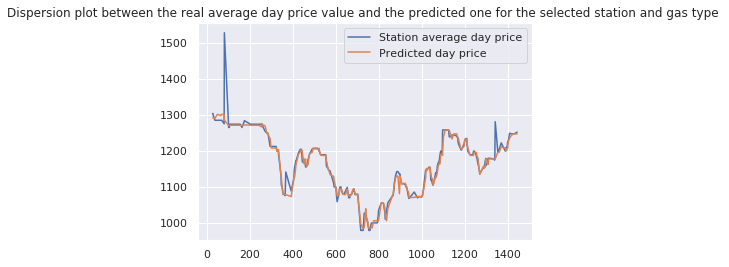

In [63]:
plt.plot(dispersion_plot['Day_n'],dispersion_plot['station_day_avg'],label = 'Station average day price')
plt.plot(dispersion_plot['Day_n'], dispersion_plot['prediction'], label ='Predicted day price')
plt.title('Dispersion plot between the real average day price value and the predicted one for the selected station and gas type ')
plt.legend()


We can see that the prediction manages to fit the real average day price except for the extreme values.

In [64]:
# close sparkcontext
sc.stop()